In [1]:
import torch
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import io
import requests
import torchvision.transforms as transforms
from PIL import Image
from torchvision.transforms import Compose, Normalize, ToTensor
import torchvision.transforms as T

In [2]:
from model_tragets import ClassifierOutputTarget,ClassifierOutputSoftmaxTarget
from functions import show_cam_on_image
import functions as func
import helper as help
# from EigenCAM import EigenCAM
# from ScoreCAM import ScoreCAM
# from AblationCAM import AblationCAM

In [3]:
import numpy as np
import scipy.sparse
import numpy.linalg as LA
from scipy.stats import entropy
from sys import exit

class NMFBase():

	def __init__(self, X, rank=10, **kwargs):

		self.X = X
		self._rank = rank


		self.X_dim, self._samples = self.X.shape

	def frobenius_norm(self):
		""" Euclidean error between X and W*H """

		if hasattr(self,'H') and hasattr(self,'W'):
			error = LA.norm(self.X - np.dot(self.W, self.H))
		else:
			error = None

		return error

	def kl_divergence(self):
		""" KL Divergence between X and W*H """

		if hasattr(self,'H') and hasattr(self,'W'):
			V = np.dot(self.W, self.H)
			error = entropy(self.X, V).sum()
		else:
			error = None

		return error

	def initialize_w(self):
		""" Initalize W to random values [0,1]."""

		self.W = np.random.random((self.X_dim, self._rank))

	def initialize_h(self):
		""" Initalize H to random values [0,1]."""

		self.H = np.random.random((self._rank, self._samples))

	def update_h(self):
		"Override in subclasses"
		pass

	def update_w(self):
		"Override in subclasses"
		pass


	def check_non_negativity(self):

		if self.X.min()<0:
			return 0
		else:
			return 1

	def compute_factors(self, max_iter=100):
		if self.check_non_negativity():
			pass

		if not hasattr(self,'W'):
			self.initialize_w()

		if not hasattr(self,'H'):
			self.initialize_h()


		self.frob_error = np.zeros(max_iter)

		for i in range(max_iter):

			self.update_w()

			self.update_h()

			self.frob_error[i] = self.frobenius_norm()
            
            

import cvxopt
from cvxopt import matrix, solvers
import numpy as np
from numpy import random
import numpy.linalg as LA
import sys



import numpy as np
from numpy import random
import numpy.linalg as LA
from sys import exit


class FPDNMF(NMFBase):

	"""
	Attributes
	----------
	W : matrix of basis vectors
	H : matrix of coefficients
	frob_error : Frobenius norm
	div_error  : KL Divergence Error
	"""
	def initialize_vars(self):

		self.Wbar= self.W
		self.Wold= self.W

		self.Hbar= self.H
		self.Hold= self.H

		self.chi = -self.X / np.dot(self.W, self.H)
		self.chi1 = np.max( (np.dot(self.W.T, self.chi).T * (1.0/np.sum(self.W, 0))).T  , 0)
		self.chi = self.chi* (1.0/self.chi1)

	def compute_factors(self, max_iter=100, nditer=5):

		if self.check_non_negativity():
			pass

		if not hasattr(self,'W'):
			self.initialize_w()

		if not hasattr(self,'H'):
			self.initialize_h()

		self.initialize_vars()

		m= (self.X.shape[1])
		n= (self.X.shape[0])
		r= self._rank

		sigma=0
		tau=0

		self.frob_error = np.zeros(max_iter)
		self.div_error = np.zeros(max_iter)

# 		for i in range(max_iter):
		sigma= (np.sum(self.W) / np.sum(self.X, 0)) / LA.norm(self.W)
# 		print("sigma 1")
# 		print(sigma)  
		sigma *= np.power(n/r, 0.5)
# 		print("sigma 2")
# 		print(sigma)  

		tau= ( np.sum(self.X, 0) / np.sum(self.W) ) / LA.norm(self.W)
		tau *= np.power(r/n, 0.5)

# 		for j in range(nditer):
		self.update_h(sigma, tau)


		sigma= (np.sum(self.W) / np.sum(self.X, 0)) / LA.norm(self.W)
# 		print("sigma 3")
# 		print(sigma)  
		sigma *= np.power(n/r, 0.5)
# 		print("sigma 4")
# 		print(sigma)  

		tau= ( np.sum(self.X, 1) / np.sum(self.H) ) / LA.norm(self.H)
		tau *= np.power(r/m, 0.5)

# 		for j in range(nditer):
		self.update_w(sigma, tau)

		self.frob_error[0] = self.frobenius_norm()
		self.div_error[0] = self.kl_divergence()


	def update_h(self, sigma, tau):
		sigma = np.nan_to_num(sigma)
		self.chi += (np.dot(self.W, self.Hbar) * sigma)
		self.chi = np.nan_to_num(self.chi)
		self.chi = (self.chi - np.sqrt( np.square(self.chi) + (self.X * (4*sigma) ) ))/2
		self.chi = np.nan_to_num(self.chi)
		self.H = self.H - np.dot(self.W.T, (self.chi+1)) * tau
		self.H = np.nan_to_num(self.H)
		self.H[self.H<0] = 0.0
		self.H = np.nan_to_num(self.H)

		self.Hbar= 2*self.H- self.Hold
		self.Hbar = np.nan_to_num(self.Hbar)
		self.Hold= self.H
		self.Hold = np.nan_to_num(self.Hold)

# 	def update_w(self, sigma, tau):
# 		print("W : ")
# 		print(self.W)
# 		self.chi += (np.dot(self.Wbar, self.H) * sigma)
# 		self.chi = (self.chi - np.sqrt( np.square(self.chi) + (self.X * (4*sigma) ) ))/2
# 		self.W = self.W - (np.dot((self.chi+1), self.H.T).T * tau).T
# 		self.W[self.W<0] = 0.0

# 		self.Wbar= 2*self.W- self.Wold
# 		self.Wold= self.W


	def update_w(self, sigma, tau):
		sigma = np.nan_to_num(sigma)
		self.chi += (np.dot(self.Wbar, self.H) * sigma)
		self.chi = np.nan_to_num(self.chi)
		self.chi = (self.chi - np.sqrt( np.square(self.chi) + (self.X * (4*sigma) ) ))/2
		self.chi = np.nan_to_num(self.chi)
		self.W = self.W - (np.dot((self.chi+1), self.H.T).T * tau).T
		self.W = np.nan_to_num(self.W)
		self.W[self.W<0] = 0.0
		self.W = np.nan_to_num(self.W)

		self.Wbar= 2*self.W- self.Wold
		self.Wbar = np.nan_to_num(self.Wbar)
		self.Wold= self.W
		self.Wold = np.nan_to_num(self.Wold)
            



def get_2d_projection_og_2(activation_batch):
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        fpdnmf= FPDNMF(reshaped_activations, rank=2048)
        fpdnmf.compute_factors(max_iter=1, nditer=2)
        Ww = fpdnmf.W
        Hh = fpdnmf.H
#         Hh = Hh.astype('float32')
        reshaped_activations_out = np.nan_to_num(reshaped_activations) 
        Hh_out = np.nan_to_num(Hh) 
        projection = reshaped_activations_out @ Hh_out[0, :]
        projection = projection.reshape(activations.shape[1:])
        projections.append(projection)
    return np.float32(projections)



In [4]:
from base import BaseCAM  

    


    
class Primal_dual(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(Primal_dual, self).__init__(model,
                                       target_layers,
                                       use_cuda,
                                       reshape_transform,
                                       uses_gradients=False)

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        return get_2d_projection_og_2(activations)
    


In [5]:
from base import BaseCAM

def helper(activation_batch):
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshaped_activations = reshaped_activations - \
            reshaped_activations.mean(axis=0)
        U, S, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
        projection = reshaped_activations @ VT[0, :]
        projection = projection.reshape(activations.shape[1:])
        projections.append(projection)
    return np.float32(projections)


class EigenCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(EigenCAM, self).__init__(model,
                                       target_layers,
                                       use_cuda,
                                       reshape_transform,
                                       uses_gradients=False)

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        return helper(activations)

In [6]:
from base import BaseCAM  


class GradCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        target_category,
                        activations,
                        grads):
        return np.mean(grads, axis=(2, 3))

In [7]:
# Showing the metrics on top of the CAM : 
def visualize_score(visualization, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
#     visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
#                                 cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
#     visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
#                                 cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
#     visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
#                                 cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
#     visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
#                                 cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("Primal_dual", Primal_dual(model=model, target_layers=target_layers)),
               ("EigenCAM", EigenCAM(model=model, target_layers=target_layers)),
              ("GradCAM", GradCAM(model=model, target_layers=target_layers))]

    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
#         global attributions
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                          targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        visualization = show_cam_on_image(cg, attribution, use_rgb=True)
        visualization = visualize_score(visualization, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))


def preprocess_image(
    img: np.ndarray, mean=[
        0.5, 0.5, 0.5], std=[
            0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)


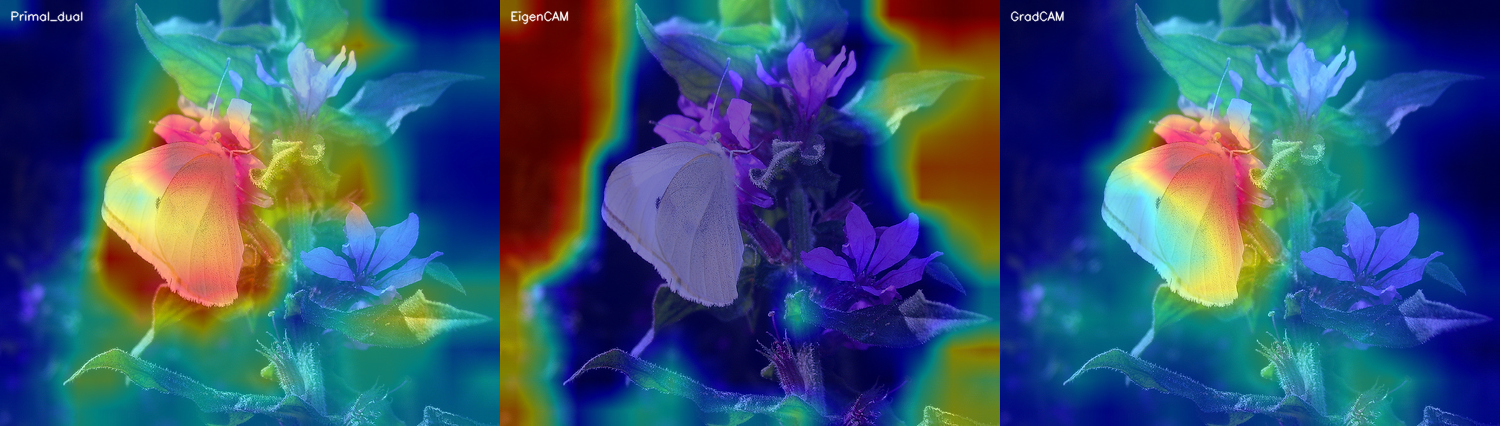

In [10]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000031.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (170,170))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(iimage)
tensor = tensor.reshape([ 170,170,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

perturbated

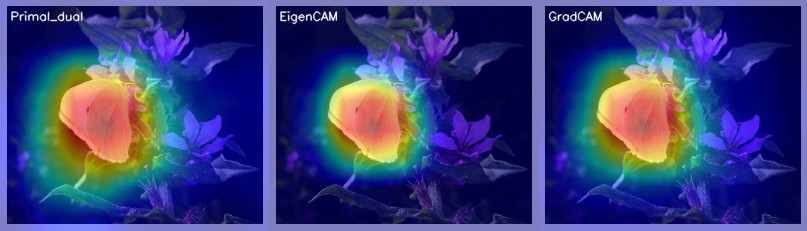

In [8]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/output_butterfly.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (204, 204))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(iimage)
tensor = tensor.reshape([ 204, 204,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

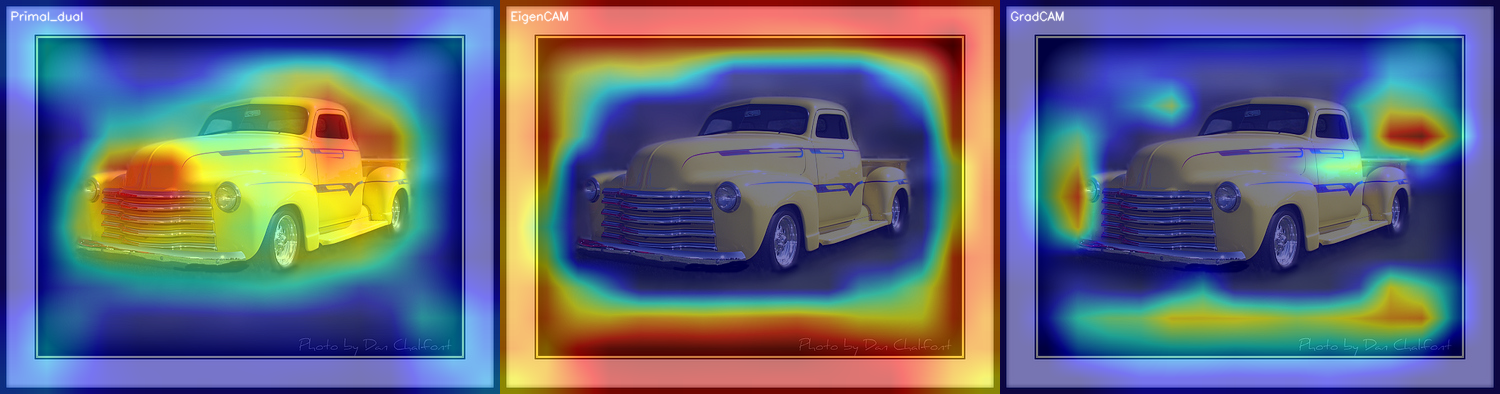

In [11]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000049.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (104, 104))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(iimage)
tensor = tensor.reshape([ 104, 104,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

perturbated

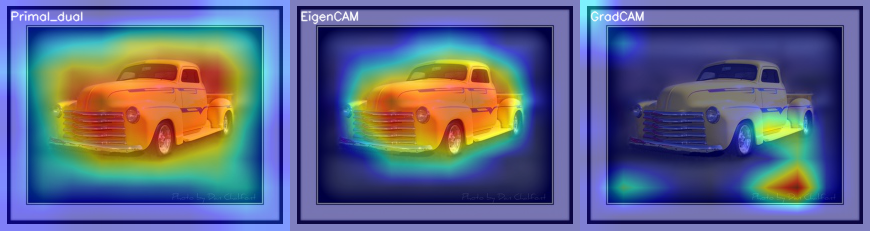

In [9]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/outputcar.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (104, 104))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(iimage)
tensor = tensor.reshape([ 104, 104,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

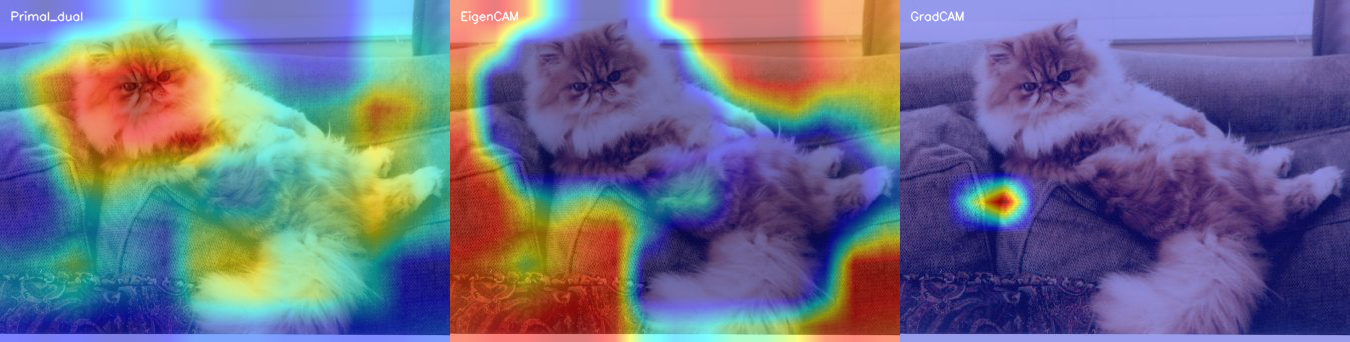

In [12]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/ILSVRC2012_val_00000130.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (104, 104))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(iimage)
tensor = tensor.reshape([ 104, 104,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)

perturbated

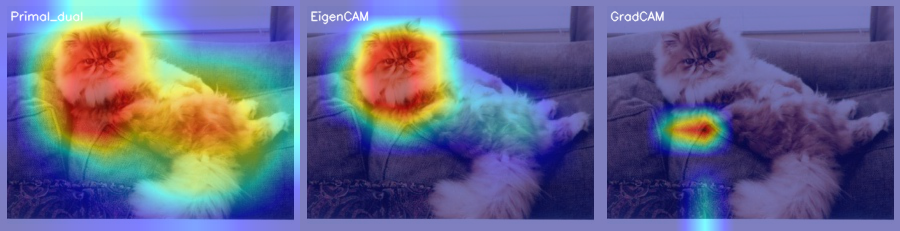

In [10]:
url = requests.get('https://raw.githubusercontent.com/onMeaSy/Non_Gradient_CAM/master/images/output_cat.jpg',stream=True)
model = models.resnet50(pretrained=True)
iimage = Image.open(io.BytesIO(url.content))
size = iimage.size
# define transformt o resize the image with given size
transform = T.Resize(size = (104, 104))

# apply the transform on the input image
image = transform(iimage)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(iimage)
tensor = tensor.reshape([ 104, 104,3])
cg = Image.fromarray(img)
cg = np.float32(cg) / 255
#display(let)
input_tensor = preprocess_image(cg, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

#model.cuda()
#input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False,category=324)